# Batch learning and evaluation scripts demo

For general use, want a more structured pipeline than experimental notebooks provide. This includes:
* an experiment definition file 
* running from the command line / python interpreter
* being able to run on a batch system like spice
* run one of
  * a training experiment, which trains classifiers and produces metrics
  * run inference, which loads previously trained classifiers and performs classifications on the whole dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import pathlib

In [2]:
import matplotlib
import matplotlib.pyplot
import cartopy.crs as ccrs


In [3]:
root_repo_dir = pathlib.Path().absolute().parent
sys.path = [os.path.join(root_repo_dir)] + sys.path

In [4]:
from classification import experiment

## Set up parameters
Define some key paths for the experiment. Paths are not generally defined in experiment description, to make the experiment description more portable.
Import definitions include
* The root data directory. This should have subdirectories with the XBT input dataset, as well as for outputs.
* The names of the input and output subdirectories
* The path to JSON experiment description file. 

In [5]:
# Set up some site specific parameters for the notebook
try:
    environment = os.environ['XBT_ENV_NAME']
except KeyError:
    environment = 'pangeo'

In [6]:
root_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/',
    'pangeo': '/data/misc/xbt-data/',
}
env_date_ranges = {
    'MO_scitools': (1966,2015),
    'pangeo': (1966,2015)
}


In [7]:
# Set up some dataset specific parameters
root_data_dir = root_data_dirs[environment]
year_range = env_date_ranges[environment]

In [8]:
input_dir_name = 'csv_with_imeta'
exp_out_dir_name = 'experiment_outputs'

In [9]:
xbt_input_dir = os.path.join(root_data_dir, input_dir_name)
xbt_output_dir = os.path.join(root_data_dir, exp_out_dir_name)

In [10]:
json_params_path = os.path.join(root_repo_dir, 'examples', 'xbt_param_decisionTree_country.json')

Creating the experiment object will load all the definitions from JSON file but does not run the experiment. We have 3 choices of experiment using the following functions:
* `run_single_experiment` - Run training, inference and evaluation with a single split, no cross-validation or hyperparameter tuning. Save classifier, metrics and classifications if requested (default is to output results).
* `run_cvhpt_experiment` -  Run training, inference and evaluation with cross-validation and hyperparameter tuning:
  * Use outer cross validation based on cruise number
  * Run hyperparameter tuning on each outer split using grid search.
  * Run inner cross-validation for each set of parameters being tried. 
  * Save classifiers, metrics and classifications if requested (default is to output results). 
  * Save a json file for running inference in future, which points to files containing trained classifiers.
  * Calculate a vote-based probability using the ensemble of classifiers trained on different splits.
* `run_inference` - Load previous classifiers and run inference. See below for more details.

In [11]:
exp2_cv = experiment.ClassificationExperiment(json_params_path, xbt_input_dir, xbt_output_dir)

In [12]:
%%time
results_cv, classifiers_cv = exp2_cv.run_cvhpt_experiment()

loading dataset
generating splits
creating hyperparameter tuning objects
running cross validation
calculating metrics
exporting classifier objects through pickle
 writing inference experiment output file to /data/misc/xbt-data/experiment_outputs/decisionTree_country/xbt_param_decisionTree_country_inference.json
CPU times: user 17min 11s, sys: 25.4 s, total: 17min 36s
Wall time: 57min 33s


The trained classifier objects are saved to the output directory, one per file. There is also a JSON experiment description file, which is the same as the original description, but with inference added to experiment name and a list of classifier file names. This file can be used to create and run an inference job. The classifier files should be in the same directory as the JSON inference description files.

In [13]:
json_inf_path = exp2_cv.inference_out_json_path

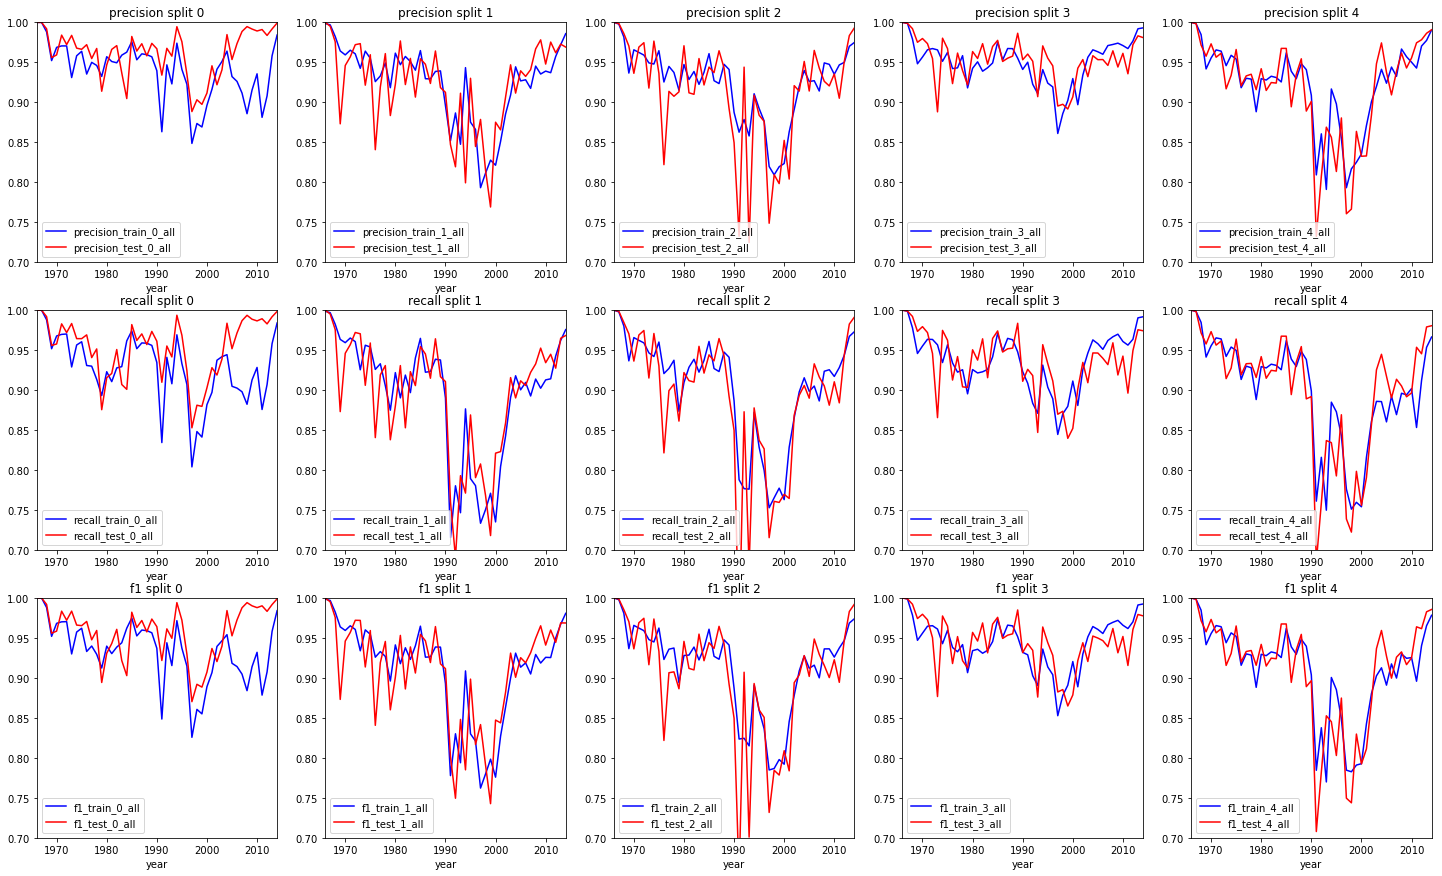

In [14]:
fig_results = matplotlib.pyplot.figure('xbt_results',figsize=(25,15))
for label1, metrics1  in classifiers_cv.items():
    ax_precision = fig_results.add_subplot(3,5,label1 +1, title='precision split {0}'.format(label1))
    ax_recall = fig_results.add_subplot(3,5,label1 + 1 + 5 * 1, title='recall split {0}'.format(label1))
    ax_f1 = fig_results.add_subplot(3,5,label1 + 1 + 5 * 2, title='f1 split {0}'.format(label1))
    results_cv.plot.line(ax=ax_precision, x='year', y=[f'precision_train_{label1}_all',f'precision_test_{label1}_all'], color=['b', 'r'], ylim=(0.7,1.0))
    results_cv.plot.line(ax=ax_recall, x='year', y=[f'recall_train_{label1}_all',f'recall_test_{label1}_all'], color=['b', 'r'], ylim=(0.7,1.0))
    results_cv.plot.line(ax=ax_f1, x='year', y=[f'f1_train_{label1}_all',f'f1_test_{label1}_all'], color=['b', 'r'], ylim=(0.7,1.0))

### Inference
Once we have trained the classifiers, we want to be able to load from the saved state files and run inference on the whole dataset, with the same results. We can use the JSOn file created by the training to run the inference. The JSON inference parameters and the saved classifier object files should be in the same directory. We can then use the `run_inference` function. This will perform the following steps:
* load dataset
* load previously classifiers from file list defined in JSON inference description.
* run inference for each of the classifiers
* fill in classifications where not possible with classifiers using iMeta algorithm
* calculate vote-based probability using ensemble of previously trained classifiers
* save classification results

In [15]:
exp3_inf = experiment.ClassificationExperiment(json_inf_path, xbt_input_dir, xbt_output_dir)


In [16]:
%%time
classifiers_reloaded = exp3_inf.run_inference()

loading dataset
loading saved classifiers from pickle files.
generate imeta algorithm results for the whole dataset
 run prediction on full dataset
generate vote count probabilities from the different trained classifiers
output predictions
CPU times: user 15min 5s, sys: 21.8 s, total: 15min 27s
Wall time: 19min 35s
